<a href="https://colab.research.google.com/github/Anshu00027/pde_sae/blob/main/TVG_PINNs_SAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# We are loading the data collected from a trained PINNs model with architecture [3, 25, 25, 3], solving Taylor Vortex Green problem, considering the activations of the last hidden layer (the second hidden layer) which contains 25 neurons
# These activations are collected for all training points(3475). so the shape should be (3475,25)
activations_array = np.load("/content/drive/MyDrive/SAE_project/last_hidden_activations.npy")
print(activations_array.shape)

(3475, 25)


In [4]:
# Use all activations from last hidden layer
hidden_tensor = torch.tensor(activations_array, dtype=torch.float32)

# Dataset (input,output)
dataset = TensorDataset(hidden_tensor, hidden_tensor)
dataloader = DataLoader(dataset, batch_size=139, shuffle=True)
# Here, we use mini-batching to improve training efficiency. Instead of processing all 3,475 activation samples at once in a single epoch, the data is divided into smaller batches of 139 samples each. The model iteratively trains on these mini-batches, completing one full pass (epoch) after all batches are processed.


# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda, sparsity_target,xavier_norm_init=True):    # These parameters control the sparsity constraint in the sparse autoencoder.
        super().__init__()                                                               # The sparsity_target defines the desired average activation level of the hidden neurons encouraging most neurons to remain inactive for a given input.
                                                                                         # The sparsity_lambda determines how strongly this sparsity penalty influences the total loss during training.
        self.xavier_norm_init = xavier_norm_init
        self.encoder = nn.Sequential(                   # The encoder consists of a fully connected layer that maps the input features to a hidden space (h_dims),by a Sigmoid activation function.
            nn.Linear(in_dims, h_dims),
            nn.Sigmoid() )

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)
            nn.init.constant_(self.encoder[0].bias, 0)

        self.decoder = nn.Sequential(                 # The decoder reconstructs the original input from the compressed hidden representation.
            nn.Linear(h_dims, in_dims),
            nn.Tanh())

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)
            nn.init.constant_(self.decoder[0].bias, 0)

        self.sparsity_lambda = sparsity_lambda
        self.sparsity_target = sparsity_target

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
                                                                              # This function computes the KL sparsity penalty, which encourages the hidden layer activations to remain close to a target sparsity level. This sparsity penalty is applied on the encoded activations
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = 1e-8
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1-epsilon)
        kl_div = rho * torch.log(rho / rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat))
        return self.sparsity_lambda * torch.sum(kl_div)

    def loss_function(self, decoded, x, encoded):
        mse_loss = nn.functional.mse_loss(decoded, x)
        return mse_loss + self.sparsity_penalty(encoded)

# Initialize and train
in_dims = hidden_tensor.shape[1]
h_dims = 50
sparsity_lambda=1e-4
sparsity_target=0.005
sae = SparseAutoencoder(in_dims, h_dims,sparsity_lambda, sparsity_target)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sae.to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)

# Training
n_epochs = 200
last_batch_encoded = None

for epoch in range(n_epochs):
    total_loss = 0
    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        encoded, decoded = sae(batch_x)
        loss = sae.loss_function(decoded, batch_x, encoded)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Keep last batch activations
        last_batch_encoded = encoded.detach().cpu().numpy()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {total_loss/len(dataloader):.6f}")

# After training
np.save("last_batch_encoded.npy", last_batch_encoded)
print("Saved last mini-batch encoded activations:", last_batch_encoded.shape)


# Save the encoded representation
with torch.no_grad():
    encoded, _ = sae(hidden_tensor.to(device))

encoded = encoded.cpu().numpy()
np.save("train_last_hidden_encoded.npy", encoded)
print("Saved SAE encoded features shape:", encoded.shape)

Epoch 1/200 - Loss: 3.266984
Epoch 11/200 - Loss: 1.979028
Epoch 21/200 - Loss: 1.966092
Epoch 31/200 - Loss: 1.962029
Epoch 41/200 - Loss: 1.959912
Epoch 51/200 - Loss: 1.957959
Epoch 61/200 - Loss: 1.955811
Epoch 71/200 - Loss: 1.954546
Epoch 81/200 - Loss: 1.953643
Epoch 91/200 - Loss: 1.952906
Epoch 101/200 - Loss: 1.952284
Epoch 111/200 - Loss: 1.951733
Epoch 121/200 - Loss: 1.951234
Epoch 131/200 - Loss: 1.950820
Epoch 141/200 - Loss: 1.950487
Epoch 151/200 - Loss: 1.950193
Epoch 161/200 - Loss: 1.949937
Epoch 171/200 - Loss: 1.949703
Epoch 181/200 - Loss: 1.949491
Epoch 191/200 - Loss: 1.949295
Saved last mini-batch encoded activations: (139, 50)
Saved SAE encoded features shape: (3475, 50)


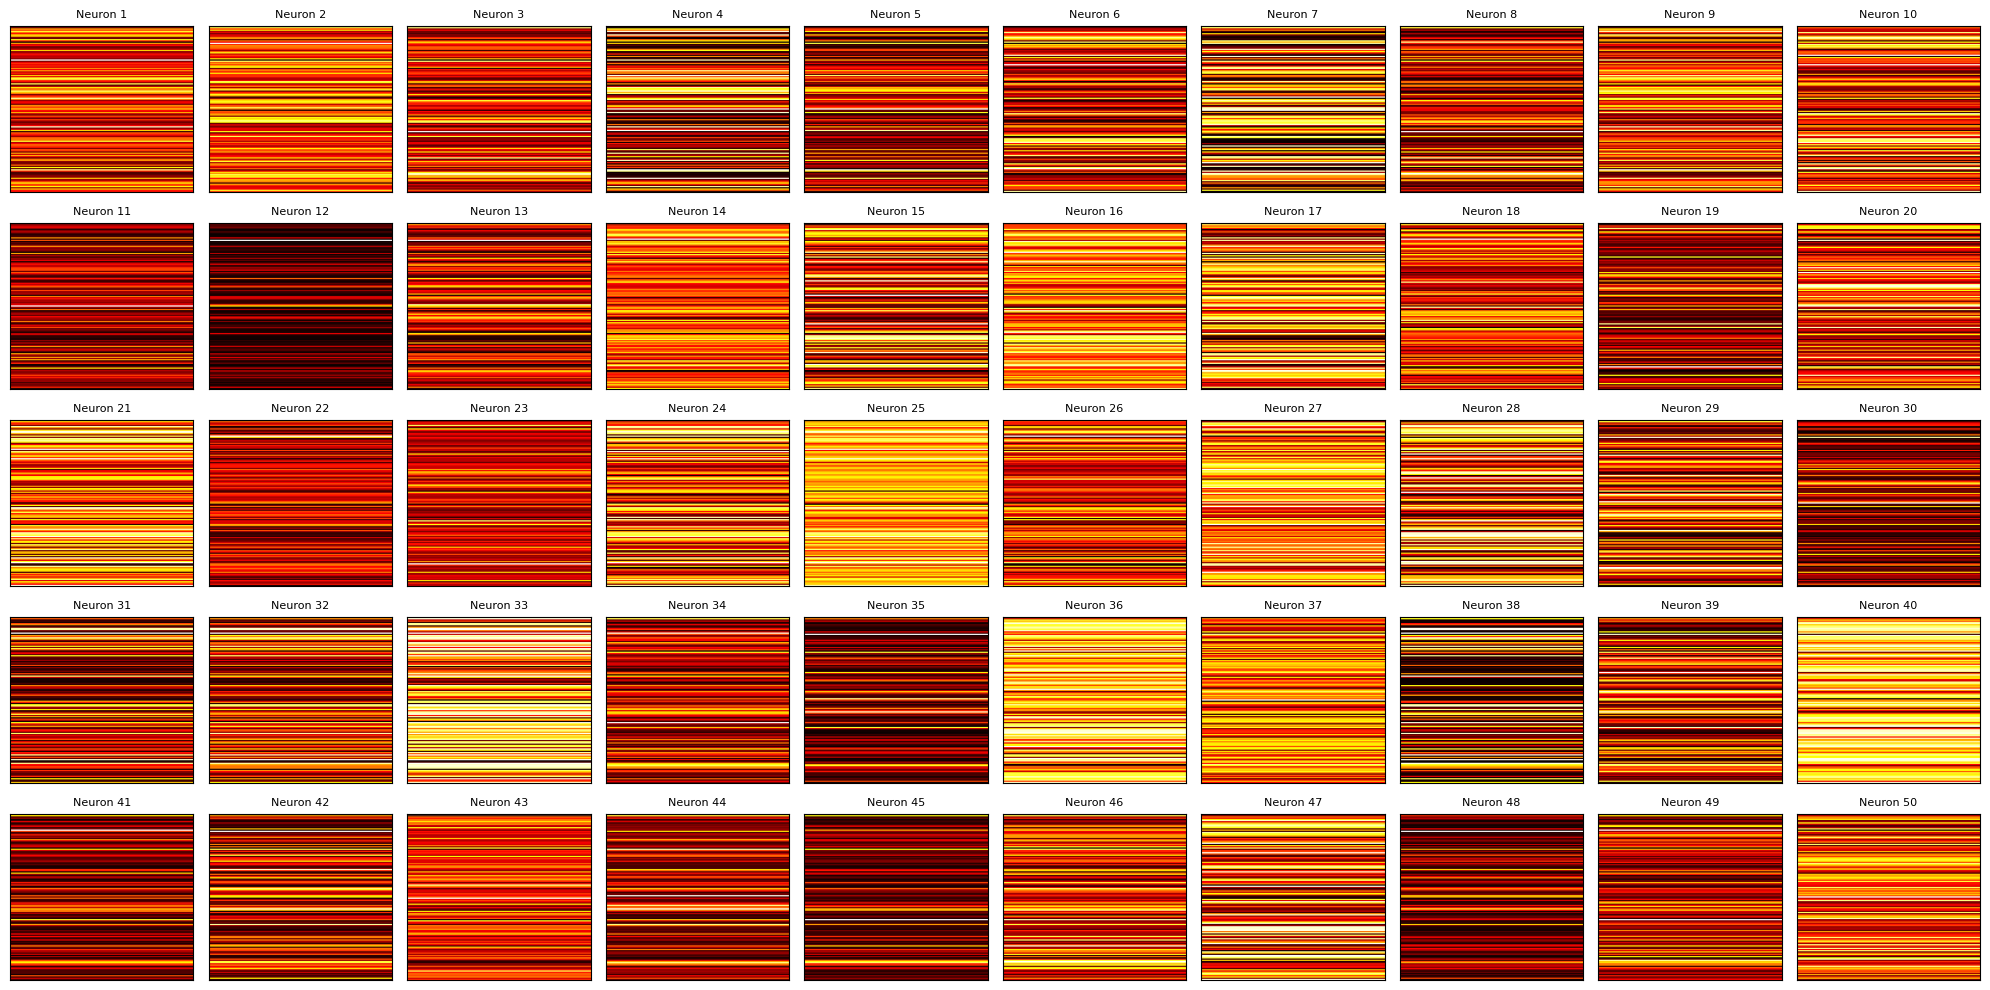

In [5]:
import matplotlib.pyplot as plt
def plot_last_batch_activations(activations, num_neurons, neurons_per_row, save_path=None):
    num_rows = (num_neurons + neurons_per_row - 1) // neurons_per_row
    fig, axes = plt.subplots(num_rows, neurons_per_row, figsize=(neurons_per_row * 2, num_rows * 2))
    axes = axes.flatten()

    for i in range(num_neurons):
        if i >= activations.shape[1]:
            break
        ax = axes[i]
        # Each neuron activation across the last batch samples
        ax.imshow(activations[:, i].reshape(-1, 1), aspect='auto', cmap='hot')
        ax.set_title(f'Neuron {i+1}', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

# call
plot_last_batch_activations(last_batch_encoded, num_neurons=h_dims, neurons_per_row=10, save_path="last_batch_activations.png")